# Deep learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
df_train = pd.read_csv('./train/train.csv')
df_test = pd.read_csv('./test/test.csv')
df_train.Description

0        Nibble is a 3+ month old ball of cuteness. He ...
1        I just found it alone yesterday near my apartm...
2        Their pregnant mother was dumped by her irresp...
3        Good guard dog, very alert, active, obedience ...
4        This handsome yet cute boy is up for adoption....
                               ...                        
14988    I have 4 kittens that need to be adopt urgentl...
14989    Serato(female cat- 3 color) is 4 years old and...
14990    Mix breed, good temperament kittens. Love huma...
14991    she is very shy..adventures and independent..s...
14992    Fili just loves laying around and also loves b...
Name: Description, Length: 14993, dtype: object

#### 1. Feature engineering

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
df_train.Description = df_train.Description.astype(str)
df_test.Description = df_train.Description.astype(str)

In [5]:
tokenizer = Tokenizer(num_words=20000, oov_token='OOV')
tokenizer.fit_on_texts(df_train.Description)

In [8]:
len(tokenizer.index_word)

21809

- tokernizer: encode từ thành số. I = 1, am = 30, ...
- text_to_sequence: encode câu thành dãy các số. My name is = [3, 100, 44]
- pad_sequence: padding câu về cùng độ dài. My name is = [3, 100, 44, 0, 0, 0, 0, 0, 0, 0]

In [9]:
train_sequence = tokenizer.texts_to_sequences(df_train.Description)
test_sequence = tokenizer.texts_to_sequences(df_test.Description)

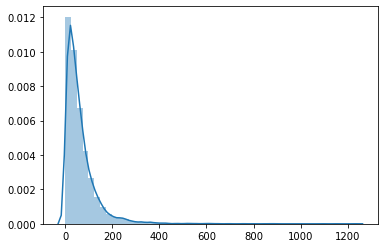

In [10]:
sns.distplot([len(train_sequence[i]) for i in range(len(df_train))])

In [11]:
pad_train = pad_sequences(train_sequence, maxlen=140)
pad_test = pad_sequences(test_sequence, maxlen=140)

In [18]:
y_train = np.eye(5)[df_train.AdoptionSpeed]

In [19]:
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.model_selection import train_test_split

In [20]:
X_training, X_valid, y_training, y_valid = train_test_split(pad_train, y_train, test_size=0.2, random_state=1)

#### 2. Build model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM, Dropout

In [16]:
import tensorflow as tf
tf.random.Generator = None  # Patch for a bug
import tensorflow_addons as tfa

In [14]:
model = Sequential([Embedding(20000, 32, input_length=140),
                    LSTM(32),
                    Dense(64, activation='relu'),
                    Dropout(0.2),
                    Dense(5, activation='softmax')   
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 140, 32)           640000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 650,757
Trainable params: 650,757
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(optimizer='adam', loss=tfa.losses.kappa_loss.WeightedKappaLoss(num_classes=5), metrics=['acc'])

In [23]:
history = model.fit(X_training, y_training, epochs=10, validation_data=(X_valid, y_valid))

Train on 11994 samples, validate on 2999 samples
Epoch 1/10
11994/11994 [==============================] - 31s 3ms/sample - loss: -0.0122 - acc: 0.2562 - val_loss: -0.0601 - val_acc: 0.2541
Epoch 2/10
11994/11994 [==============================] - 28s 2ms/sample - loss: -0.2286 - acc: 0.2631 - val_loss: -0.2118 - val_acc: 0.2344
Epoch 3/10
11994/11994 [==============================] - 28s 2ms/sample - loss: -0.5080 - acc: 0.3357 - val_loss: -0.2420 - val_acc: 0.2928
Epoch 4/10
11994/11994 [==============================] - 29s 2ms/sample - loss: -0.7403 - acc: 0.4142 - val_loss: -0.2439 - val_acc: 0.3024
Epoch 5/10
11994/11994 [==============================] - 28s 2ms/sample - loss: -0.9337 - acc: 0.4508 - val_loss: -0.2373 - val_acc: 0.3191
Epoch 6/10
11994/11994 [==============================] - 29s 2ms/sample - loss: -1.0478 - acc: 0.4786 - val_loss: -0.2181 - val_acc: 0.3161
Epoch 7/10
11994/11994 [==============================] - 27s 2ms/sample - loss: -1.1348 - acc: 0.4965 - 

#### Validation

In [25]:
pred = model.predict(X_valid)
y_pred = np.argmax(pred, axis=1)
y_val = np.argmax(y_valid, axis=1)

In [26]:
accuracy_score(y_pred, y_val)

0.3047682560853618

In [27]:
cohen_kappa_score(y_pred, y_val, weights='quadratic')

0.19902294811889798

In [28]:
from collections import Counter

In [29]:
Counter(y_pred)

Counter({4: 820, 1: 901, 3: 558, 2: 720})

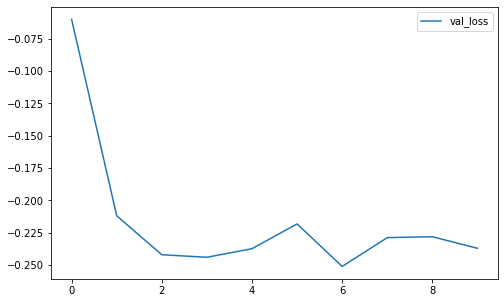

In [33]:
plt.figure(figsize=(8,5))
#plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.legend(['loss', 'val_loss'])
plt.legend(['val_loss'])

# TF-IDF

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import save_npz, load_npz

In [2]:
train_desc_df = pd.read_csv('./train/train.csv')[['Description', 'PetID', 'AdoptionSpeed']]
test_desc_df = pd.read_csv('./test/test.csv')[['Description', 'PetID']]

In [3]:
train_desc_df.Description.isnull().sum(), test_desc_df.Description.isnull().sum()

(12, 1)

In [4]:
train_desc_df.Description.fillna('', inplace=True)
test_desc_df.Description.fillna('', inplace=True)

In [5]:
train_desc_df.tail()

,Description,PetID,AdoptionSpeed
14988,I have 4 kittens that need to be adopt urgentl...,dc0935a84,2
14989,Serato(female cat- 3 color) is 4 years old and...,a01ab5b30,4
14990,"Mix breed, good temperament kittens. Love huma...",d981b6395,3
14991,she is very shy..adventures and independent..s...,e4da1c9e4,4
14992,Fili just loves laying around and also loves b...,a83d95ead,3


In [6]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(4,4), analyzer='char_wb', min_df=10, max_df=0.6, strip_accents='unicode')
X_train = vectorizer.fit_transform(train_desc_df.Description)
X_test = vectorizer.transform(test_desc_df.Description)
y_train = train_desc_df.AdoptionSpeed

In [12]:
save_npz('train_desc_df.npz', X_train)
save_npz('test_desc_df.npz', X_test)

In [13]:
#pd.DataFrame(X_train.toarray().astype('float32')).to_pickle('train_desc_df.pkl')
#pd.DataFrame(X_test.toarray().astype('float32')).to_pickle('test_desc_df.pkl')

In [18]:
# import pickle

# file_train = open('train_desc_df.pkl', 'rb')
# X_train = pickle.load(file_train)
# file_train.close()

# file_test = open('test_desc_df.pkl', 'rb')
# X_test = pickle.load(file_test)
# file_test.close()

In [14]:
X_train = load_npz('train_desc_df.npz')
X_test = load_npz('test_desc_df.npz')

In [15]:
X_train

<14993x12991 sparse matrix of type '<class 'numpy.float64'>'
	with 2406786 stored elements in Compressed Sparse Row format>

### Model

In [10]:
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.model_selection import train_test_split

In [11]:
X_training, X_valid, y_training, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

#### Random Forest

In [12]:
model_rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
model_rf.fit(X_training, y_training)
predicts_rf = model_rf.predict(X_valid)
accuracy_score(predicts_rf, y_valid)

0.347782594198066

In [13]:
cohen_kappa_score(predicts_rf, y_valid, weights='quadratic')

0.10422108158167709

#### Light GBM

In [14]:
model_lgb = lgb.LGBMClassifier(random_state=0, learning_rate=0.1)
model_lgb.fit(X_training, y_training)
predicts_lgb = model_lgb.predict(X_valid)
accuracy_score(predicts_lgb, y_valid)

0.3801267089029677

In [15]:
cohen_kappa_score(predicts_lgb, y_valid, weights='quadratic')

0.23013618582836382

#### TF

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
tf.random.Generator = None  # Patch for a bug
import tensorflow_addons as tfa

c:\users\admin\tf2\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.1.0-rc0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [17]:
y_train_tf = np.eye(5)[y_training]
y_valid_tf = np.eye(5)[y_valid]

In [18]:
model = Sequential([Dense(128, activation='relu', input_shape=[X_train.shape[1]]),
                    Dropout(0.2),
                    Dense(5, activation='softmax')
])
model.compile(optimizer='adam', loss=tfa.losses.kappa_loss.WeightedKappaLoss(num_classes=5))

In [19]:
history = model.fit(X_training.toarray(), y_train_tf, batch_size=32, epochs=10, validation_data=[X_valid.toarray(), y_valid_tf])

MemoryError: Unable to allocate 1.16 GiB for an array with shape (11994, 12991) and data type float64

In [17]:
pred = model.predict(X_valid.toarray())
y_pred = np.argmax(pred, axis=1)
y_val = np.argmax(y_valid, axis=1)

In [18]:
accuracy_score(y_pred, y_val)

0.3504501500500167

In [19]:
cohen_kappa_score(y_pred, y_val, weights='quadratic')

0.2223042490943633

In [20]:
from collections import Counter

In [21]:
Counter(y_pred)

Counter({4: 1023, 2: 849, 1: 668, 3: 459})

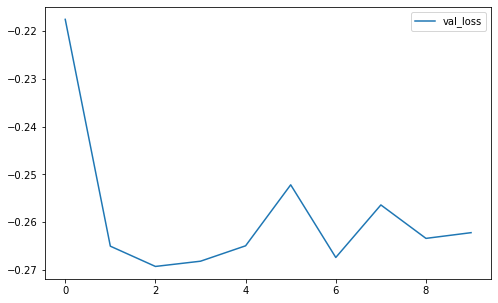

In [22]:
plt.figure(figsize=(8,5))
#plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.legend(['loss', 'val_loss'])
plt.legend(['val_loss'])

# Fasttext

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_desc_df = pd.read_csv('./train/train.csv')[['Description', 'AdoptionSpeed']]
test_desc_df = pd.read_csv('./test/test.csv')[['Description']]

#### Preprocessing

In [3]:
train_desc_df.Description.isnull().sum(), test_desc_df.Description.isnull().sum()

(12, 1)

In [4]:
train_desc_df.Description.fillna('', inplace=True)
test_desc_df.Description.fillna('', inplace=True)

In [5]:
train_desc_df.tail(3)

,Description,AdoptionSpeed
14990,"Mix breed, good temperament kittens. Love huma...",3
14991,she is very shy..adventures and independent..s...,4
14992,Fili just loves laying around and also loves b...,3


In [8]:
import re
import nltk
#nltk.download('wordnet')
#nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer

en_stop = set(nltk.corpus.stopwords.words('english'))
stemmer = WordNetLemmatizer()
def preprocess_text(document):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()

        # Lemmatization
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if word not in en_stop]
        tokens = [word for word in tokens if len(word) > 3]

        preprocessed_text = ' '.join(tokens)

        return preprocessed_text

In [9]:
train_desc_df.Description = train_desc_df.Description.apply(preprocess_text)
test_desc_df.Description = test_desc_df.Description.apply(preprocess_text)

In [11]:
n = round(len(train_desc_df)*0.8)
train_desc = train_desc_df[['AdoptionSpeed', 'Description']][:n]
valid_desc = train_desc_df[['AdoptionSpeed', 'Description']][n:]

In [12]:
#import csv

#train_desc['AdoptionSpeed']=['__label__'+ s for s in train_desc['AdoptionSpeed'].astype('str')]
#train_desc['Description']= train_desc['Description'].replace('\n',' ', regex=True).replace('\t',' ', regex=True)
#train_desc.to_csv('desc_train.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")

#valid_desc['AdoptionSpeed']=['__label__'+ s for s in valid_desc['AdoptionSpeed'].astype('str')]
#valid_desc['Description']= valid_desc['Description'].replace('\n',' ', regex=True).replace('\t',' ', regex=True)
#valid_desc.to_csv('desc_valid.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")

#### Modeling

In [13]:
import fasttext

In [14]:
model = fasttext.train_supervised(input='desc_train.txt', lr=1.0, epoch=25, 
                                  wordNgrams=2, bucket=20000, dim=32, loss='hs')

In [15]:
model.test('desc_valid.txt')

(2999, 0.3601200400133378, 0.3601200400133378)

#### Prediction

In [27]:
from sklearn.metrics import cohen_kappa_score

In [28]:
y_pred = [int(model.predict(text)[0][0][-1]) for text in valid_desc.Description]
y_val = train_desc_df.AdoptionSpeed[n:]
cohen_kappa_score(y_pred, y_val, weights='quadratic')

0.22646324921535843

In [29]:
from collections import Counter

In [30]:
Counter(y_pred)

Counter({1: 672, 4: 789, 3: 655, 2: 848, 0: 35})